# Cancer patient readmission model training
This notebook develops and evaluates machine learning models for predicting **unplanned 30-day emergency readmissions after chemotherapy** among oncology inpatients.

## Data:  
- Source: De-identified EHR data from cancer inpatients 
- 18 months cancer patient EHR
- Training set / Test set : 0.8/0.2
- Positive cases: ~0.4% (extremely imbalanced dataset)  

## Model:
Baseline：Logistic regression, class_weight="balanced",solver="liblinear", penalty="l2"\
Tree-based：XGBoost scale_pos_weight = neg/pos，max depth = 4,  XGBoost Temp scaling
Both models are evaluated using:

##  Evaluation Metrics
| Metric | Meaning |
|--------|----------|
| **AUROC** | Overall discrimination between readmission vs non-readmission |
| **AUPRC** | Precision–recall balance under extreme imbalance |
| **Brier Score** | Probability calibration quality |
| **Top-k** | Screening efficiency under limited intervention capacity |

## Features:

| Category | Variables | Description |
|-----------|------------|-------------|
| **Demographics** | `In_city`, `Gender`, `Occupation` | Basic patient info |
| **Hospitalization Info** | `Fee`, `Inhospital_days`, `Diagnose` | Admission-level data |
| **Cancer Type (ICD-10)** | `'C11','C16','C18','C20','C22','C23','C24','C25','C34','C50','C56','C61','C64','C67','C71','C79','C82','C83','C85','C90','C92','D46'` | Major solid and hematologic malignancies |
| **Surgery** | `Is_surgery`, `Class4_surgery` *(highest difficulty)*, `Surgery_complication` | Indicates surgical treatment complexity |
| **Treatment Intensity** | `RT_under_96h`, `RT_over_96h`, `ECMO`, `CRRT` | Acute or critical care indicators |
| **Within 72h before discharge** | `Ascites_72h`, `Fever_72h`, `Positive_bacteria_72h` | Short-term clinical deterioration features |


In [3]:
import os
os.chdir("..")

In [4]:
import pandas as pd
import numpy as np
import yaml
import src.data_cleaning_func as dcf
import re

## Construct dataframe for analysis 

### Read the files

In [7]:
## Args needed for file construction
MON = 18
DISKDIR = '/Users/lajikf/Desktop/Python/Projectone/data/raw'
FLASHDRIVE = '/Volumes/FENG/Projectone'
CACHEDIR = '/Users/lajikf/Desktop/Python/Projectone/data/cache'

TIMEFRAME = []
for year in [2024,2025]:
    for month in range(12):
        if month < 9:
            TIMEFRAME.append(str(year)+'0'+str(month+1))
        else:
            TIMEFRAME.append(str(year)+str(month+1))
TIMEFRAME = TIMEFRAME[:MON]


In [ ]:
## Construct facesheet dataframe
facesheet = dcf.read_concat(TIMEFRAME,DISKDIR,'face_sheet.xlsx',None)
facesheet.reset_index(drop=True, inplace=True)
facesheet.to_feather(CACHEDIR + '/facesheet.feather')

In [ ]:
## Construct the info dataframe
info = dcf.read_concat(TIMEFRAME,FLASHDRIVE,'info.xlsx',None)
info.reset_index(drop=True, inplace=True)
info.to_feather(CACHEDIR + '/info.feather')

In [ ]:
## Construct the DRG dataframe
drg = pd.read_excel('/Users/lajikf/Desktop/Python/Projectone/data/raw/2024DRG.xlsx')
temp_drg =pd.read_excel('/Users/lajikf/Desktop/Python/Projectone/data/raw/2025DRG.xlsx')
drg = pd.concat([drg,temp_drg])
del temp_drg
drg['WR'] = pd.to_numeric(drg['WR'], errors='coerce')  # 把无法转为数字的值变为 NaN
drg = drg.sort_values(by ='WR', ascending=False)
drg.reset_index(drop=True, inplace=True)
drg.drop_duplicates(subset = ['medical_record_no'], keep='first', inplace=True)
drg = pd.merge(info[['patient_id','medical_record_no','visit_sn']],drg , on='medical_record_no', how='inner')
drg[['B12']] = drg[['B12']].apply(pd.to_datetime, errors='coerce')
drg[['B15']] = drg[['B15']].apply(pd.to_datetime, errors='coerce')
drg[['surgery_date']] = drg[['surgery_date']].apply(pd.to_datetime, errors='coerce')
drg['inhospital_days'] = (drg['B15'] - drg['B12']).dt.days
drg.to_feather(CACHEDIR + '/drg.feather')

## emer_and_unplan_and_transaction_drg
emer_drg = drg[drg['inpatient_type']=='急诊']
unplan_drg = drg[drg['unplaned'] == '是']
transaction_drg = drg[drg['inpatient_type']=='其他医疗机构转入']
emer_and_unplan_drg = pd.concat([emer_drg, unplan_drg]).drop_duplicates()
emer_and_unplan_trans_drg = pd.concat([emer_drg,unplan_drg,transaction_drg]).drop_duplicates()

In [ ]:
## Construct the medical note dataframe
note  = dcf.read_concat(TIMEFRAME,FLASHDRIVE,'note.xlsx',features=None)
note.reset_index(drop=True, inplace=True)
note['record_datetime'] = note['record_datetime'].apply(pd.to_datetime, errors='coerce')
note.to_feather(CACHEDIR + '/note.feather')

### Get the readmit patient

In [ ]:
cancer_code = ['C11','C16','C18','C20','C22','C23','C24','C25','C34','C50','C56','C61','C64','C67','C71','C79','C82','C83','C85','C90','C92','D46']
tuple_master,readmit_18m,readmit_18m_firsttime = dcf.get_readmission_patients(facesheet,cancer_code, days_threshold=30)
emer_and_unplan_drg_readmit_18m = pd.merge(emer_and_unplan_drg, pd.DataFrame(readmit_18m, columns=['visit_sn']), on='visit_sn', how='inner')
emer_and_unplan_trans_drg_readmit_18m = pd.merge(emer_and_unplan_trans_drg,pd.DataFrame(readmit_18m, columns=['visit_sn']), on='visit_sn', how='inner')

### Construct analysis dataframe with basic info, DRG, and face sheet

In [ ]:
analysis_df = pd.DataFrame(facesheet['visit_sn'])
analysis_df = analysis_df.drop_duplicates()
analysis_df = analysis_df.reset_index(drop=True)
analysis_df = pd.merge(analysis_df, info[['patient_id','visit_sn','medical_record_no']], on = 'visit_sn' , how = 'inner')
analysis_df['readmit_30d'] = analysis_df['visit_sn'].apply(lambda x: 1 if x in readmit_18m else 0)
analysis_df['readmit_30d_emer_unplan'] = analysis_df['visit_sn'].apply(lambda x: 1 if x in emer_and_unplan_drg_readmit_18m['visit_sn'].values else 0)
analysis_df['readmit_30d_emer_unplan_trans'] = analysis_df['visit_sn'].apply(lambda x: 1 if x in emer_and_unplan_trans_drg_readmit_18m['visit_sn'].values else 0)
analysis_df = pd.merge(analysis_df, drg, on='medical_record_no', how='left', suffixes=('', '_drop'))
analysis_df = analysis_df.loc[:, ~analysis_df.columns.str.endswith('_drop')]
analysis_df['fee'] = pd.to_numeric(analysis_df['fee'], errors='coerce')
analysis_df['in_city'] = analysis_df['in_city'].apply(lambda x: 1 if x == '市内' else 0)
analysis_df = pd.merge(analysis_df , info[['visit_sn','gender','occupation_name','date_of_birth']], on='visit_sn', how='left')
analysis_df = analysis_df.rename(columns={'B15':'discharge_date'})
analysis_df['other_surgery_class4'] = analysis_df['other_surgery_class4'].apply(lambda x: 1 if x == '是' else 0)
analysis_df['is_surgery'] = analysis_df['is_surgery'].apply(lambda x: 1 if x == '是' else 0)
analysis_df['surgery_complication'] = analysis_df['surgery_complication'].apply(lambda x: 1 if x == '是' else 0)
analysis_df = analysis_df.rename(columns={'B12':'admission_date'})
analysis_df['RT_under_96h'] = (analysis_df['main_surgery_name'].fillna('').str.contains('呼吸机治疗[小于96',na=False,regex=False)| 
                               analysis_df['other_surgery_name'].fillna('').str.contains('呼吸机治疗[小于96',na=False,regex=False)).astype(int)
analysis_df['RT_over_96h'] = (analysis_df['main_surgery_name'].fillna('').str.contains('呼吸机治疗[大于等于96',na=False,regex=False)| 
                               analysis_df['other_surgery_name'].fillna('').str.contains('呼吸机治疗[大于等于96',na=False,regex=False)).astype(int)
analysis_df = pd.merge(analysis_df,facesheet[['visit_sn','C01C','C03C']],on='visit_sn',how='left',suffixes=('','_drop'))
analysis_df = analysis_df.loc[:,~analysis_df.columns.str.endswith("_drop")]
analysis_df = analysis_df.rename(columns={'C01C':'admission_diag_code','C03C':'discharge_diag_code'})
analysis_df['diag_combine'] = analysis_df['admission_diag_code'].str[0:3] + '-' + analysis_df['discharge_diag_code'].str[0:3]

def code_classification(input_code,cancer):
    result = 'other'
    for code in cancer:
        if (input_code[0:3]== code) | (input_code[4:7] == code):
            result = code
    return result
analysis_df['cancer_code'] = analysis_df['diag_combine'].apply(lambda x: code_classification(x,cancer_code))

analysis_df['ECMO'] = (analysis_df['main_surgery_name'].fillna('').str.contains('ECMO',na=False,regex=False)| 
                               analysis_df['other_surgery_name'].fillna('').str.contains('ECMO',na=False,regex=False)).astype(int)
analysis_df['CRRT'] = (analysis_df['main_surgery_name'].fillna('').str.contains('CRRT',na=False,regex=False)| 
                               analysis_df['other_surgery_name'].fillna('').str.contains('CRRT',na=False,regex=False)).astype(int)


In [ ]:

analysis_df[analysis_df['readmit_30d_emer_unplan'] == 1].iloc[5,:]

analysis_df.to_feather(CACHEDIR + '/analysis_df.feather')

### Build a function filtering expressions in medical note

Use the function to distinguish ascites, fever, and positive bacterial microbiological cluture

In [ ]:
def note_filter(string, expression, neg_core, window):
    """
    Filter medical notes based on the presence of specific expressions within a defined timeframe around a reference event.
    
    Args:
        string: medical notes
        expression (list): List of expressions to search for in the notes.
        neg_core (list): List of negation terms to exclude notes containing them.
        window (int): Number of charecters before and after the expression to consider.
        
    Returns:
        true or false
    """

    import re
    neg_core = [neg.lower() for neg in neg_core]
    expression = [exp.lower() for exp in expression]
    string = string.lower()
    sentences = re.split(r'[，,；;。]', string)  # Split by Chinese punctuation
    for sentence in sentences:
     # Check each expression
        for exp in expression:
            if exp in sentence: 
                has_neg = False
                for neg in neg_core:
                    pattern = r'(?i)' + re.escape(neg) + r'(.{0,' + str(window) + r'})(' + re.escape(exp) + r')|(' + re.escape(exp) + r')(.{0,' + str(window) + r'})(.{0,' + str(window) + '})(' + re.escape(neg) + r')'
                    if re.search(pattern, sentence):
                        has_neg = True
                        break
                if not has_neg:
                    return True
    return False

In [ ]:
note_filter('未腹水，导致黄疸、胸水、凝血功能障碍、低白蛋白血症、肝性脑病等，可能需长期输白蛋白，',['腹水'],['导致','可能','如','好转','未'],10)

In [ ]:
NEG_CORE = ['导致','可能','如','好转','未见','无','没有','常规','未查','排除','未诉']
NOTE_TYPE = ['查房记录','阶段小结','接班记录','抢救记录','上级医师查房记录','首次病程记录','首次查房记录','术后记录','危急值处理记录','疑难病例讨论记录']

In [ ]:
note['腹水'] = note[note['record_title'].isin(NOTE_TYPE)]['record_content'].fillna('').apply(lambda x: note_filter(x,['腹水'],NEG_CORE,10))


TEST_NUM = 50
TEST_EXP = '腹水'
temp = note[note[TEST_EXP]==True][['record_content','record_sn']].iloc[0:TEST_NUM]
for x in range(TEST_NUM):
     string = temp.iloc[x]['record_content']
     sn = temp.iloc[x]['record_sn']
     strings = re.split(r'[，,；;。]', string)
     for sentence in strings:
         if TEST_EXP in sentence:
             print('sn:',sn,':',sentence)


In [ ]:
note['发热'] = note[note['record_title'].isin(NOTE_TYPE)]['record_content'].fillna('').apply(lambda x: note_filter(x,['发热'],NEG_CORE,20))


TEST_NUM = 50
TEST_EXP = '发热'
temp = note[note[TEST_EXP]==True][['record_content','record_sn']].iloc[0:TEST_NUM]
for x in range(TEST_NUM):
     string = temp.iloc[x]['record_content']
     sn = temp.iloc[x]['record_sn']
     strings = re.split(r'[，,；;。]', string)
     for sentence in strings:
         if TEST_EXP in sentence:
             print('sn:',sn,':',sentence)

In [ ]:
note['菌阳性'] = note[note['record_title'] == '危急值处理记录']['record_content'].fillna('').apply(lambda x: note_filter(x,['菌'],NEG_CORE,20))


TEST_NUM = 50
TEST_EXP = '菌'
temp = note[note['菌阳性']==True][['record_content','record_sn']].iloc[0:TEST_NUM]
for x in range(TEST_NUM):
     string = temp.iloc[x]['record_content']
     sn = temp.iloc[x]['record_sn']
     strings = re.split(r'[，,；;。]', string)
     for sentence in strings:
         if TEST_EXP in sentence:
             print('sn:',sn,':',sentence)

In [ ]:
note = note.rename(columns={'腹水':'ascites','发热':'fever','菌阳性':'positive_bacteria'}) # type: ignore
note.to_feather(CACHEDIR + '/note.feather')

### Combine Ascites, fever, and positive microbiological culture to the analysis dataframe

In [ ]:
analysis_df[['ascites_72h','fever_72h','positive_bacteria_72h']] = 0
for idx, row in analysis_df.iterrows():
    visit_sn = row['visit_sn']
    discharge_date = row['discharge_date']
    if pd.isna(discharge_date):
        continue
    start_window = discharge_date - pd.Timedelta(hours=72)
    notes_subset = note[(note['visit_sn'] == visit_sn) &  
                        (note['record_datetime'] >= start_window)]
    analysis_df.at[idx, 'ascites_72h'] = int(notes_subset['ascites'].any())
    analysis_df.at[idx, 'fever_72h'] = int(notes_subset['fever'].any())
    analysis_df.at[idx, 'positive_bacteria_72h'] = int(notes_subset['positive_bacteria'].any())
    if idx % 10000 == 0: # type: ignore
        print(f'Processed {idx} records')

In [ ]:
analysis_df.to_feather(CACHEDIR + '/analysis_df20251008.feather')

## Modeling

### Data preprocessing

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
from sklearn.impute import SimpleImputer

In [8]:
analysis_df = pd.read_feather(CACHEDIR + '/analysis_df20251008.feather')

In [9]:

analysis_df[analysis_df['readmit_30d_emer_unplan'] == 1]['readmit_30d_emer_unplan'].sum()

np.int64(559)

In [10]:
y = analysis_df['readmit_30d_emer_unplan_trans']
x = analysis_df.drop(columns=["visit_sn","patient_id","medical_record_no", "admission_date","discharge_date","surgery_date", "readmit_30d","readmit_30d_emer_unplan","readmit_30d_emer_unplan_trans",'unplaned','inpatient_type','date_of_birth','main_surgery_name','other_surgery_name','diag_combine'])

num_cols = x.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = x.select_dtypes(include=['object']).columns.tolist()

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)


### Logistic Analysis

In [11]:
from sklearn.linear_model import LogisticRegression

logit_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced", solver="liblinear", penalty="l2"))
])


logit_model.fit(x_train, y_train)
y_pred_proba = logit_model.predict_proba(x_test)[:,1]

print("AUROC:", roc_auc_score(y_test, y_pred_proba))
print("AUPRC:", average_precision_score(y_test, y_pred_proba))
print("Brier score:", brier_score_loss(y_test, y_pred_proba))

AUROC: 0.7935183669801905
AUPRC: 0.07362698617379786
Brier score: 0.016672862361271665


### XGBOOST

In [12]:
from xgboost import XGBClassifier

xgb_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        min_child_weight=10,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight = (y==0).sum() / (y==1).sum(),  # unbalanced adjustment
        eval_metric="aucpr",
        tree_method="hist",
        n_jobs=-1,
        random_state=42
    ))
])

xgb_model.fit(x_train, y_train)
y_pred_proba = xgb_model.predict_proba(x_test)[:,1]

print("AUROC:", roc_auc_score(y_test, y_pred_proba))
print("AUPRC:", average_precision_score(y_test, y_pred_proba))
print("Brier score:", brier_score_loss(y_test, y_pred_proba))

AUROC: 0.8588428497620492
AUPRC: 0.06141837895946893
Brier score: 0.08884509428866465


### XGBoost Temp scaling

In [13]:
from sklearn.calibration import CalibratedClassifierCV
calibrated_xgb = CalibratedClassifierCV(xgb_model.named_steps["model"], cv=5, method="sigmoid")
calibrated_xgb.fit(xgb_model.named_steps["preprocess"].transform(x_train), y_train)

y_pred_proba_cal = calibrated_xgb.predict_proba(xgb_model.named_steps["preprocess"].transform(x_test))[:,1]
print("Calibrated Brier:", brier_score_loss(y_test, y_pred_proba_cal))

Calibrated Brier: 0.004018197167676583


### topk metric

In [14]:
import numpy as np

K = [0.01, 0.03, 0.05, 0.075, 0.1]

def topk_metrics(y_true, y_prob, k=K):
    n = len(y_true)
    order = np.argsort(y_prob)[::-1]
    results = {}
    for rate in k:
        top_n = int(rate * n)
        idx = order[:top_n]
        recall = y_true.iloc[idx].sum() / y_true.sum()
        ppv = y_true.iloc[idx].sum() / top_n
        results[rate] = {'Recall': recall, 'Precision': ppv}
    return results

In [15]:
y_pred_proba_xgb = xgb_model.predict_proba(x_test)[:, 1]
results_xgb = topk_metrics(y_test, y_pred_proba_xgb, k=K)
print(f'xgb result:{results_xgb}')

y_pred_proba_logit = logit_model.predict_proba(x_test)[:, 1]
results_logit = topk_metrics(y_test, y_pred_proba_logit, k=K)
print(f'logit result:{results_logit}')

xgb result:{0.01: {'Recall': np.float64(0.23684210526315788), 'Precision': np.float64(0.09854014598540146)}, 0.03: {'Recall': np.float64(0.3684210526315789), 'Precision': np.float64(0.05103280680437424)}, 0.05: {'Recall': np.float64(0.47368421052631576), 'Precision': np.float64(0.03935860058309038)}, 0.075: {'Recall': np.float64(0.5175438596491229), 'Precision': np.float64(0.028668610301263362)}, 0.1: {'Recall': np.float64(0.5877192982456141), 'Precision': np.float64(0.024416909620991252)}}
logit result:{0.01: {'Recall': np.float64(0.2631578947368421), 'Precision': np.float64(0.10948905109489052)}, 0.03: {'Recall': np.float64(0.3508771929824561), 'Precision': np.float64(0.04860267314702309)}, 0.05: {'Recall': np.float64(0.40350877192982454), 'Precision': np.float64(0.033527696793002916)}, 0.075: {'Recall': np.float64(0.4473684210526316), 'Precision': np.float64(0.02478134110787172)}, 0.1: {'Recall': np.float64(0.5087719298245614), 'Precision': np.float64(0.021137026239067054)}}


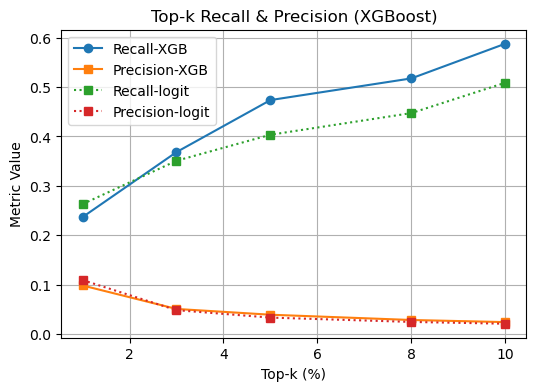

In [16]:
import matplotlib.pyplot as plt

k_vals = [round(k*100) for k in results_xgb.keys()]
recalls_xgb = [v['Recall'] for v in results_xgb.values()]
precisions_xgb = [v['Precision'] for v in results_xgb.values()]
recalls_logit = [v['Recall'] for v in results_logit.values()]
precisions_logit = [v['Precision'] for v in results_logit.values()]

plt.figure(figsize=(6,4))
plt.plot(k_vals, recalls_xgb, marker='o',linestyle='-', label='Recall-XGB')
plt.plot(k_vals, precisions_xgb, marker='s', linestyle='-',label='Precision-XGB')
plt.plot(k_vals, recalls_logit, marker='s',linestyle=':', label='Recall-logit')
plt.plot(k_vals, precisions_logit, marker='s', linestyle=':',label='Precision-logit')
plt.xlabel("Top-k (%)")
plt.ylabel("Metric Value")
plt.title("Top-k Recall & Precision (XGBoost)")
plt.legend()
plt.grid(True)
plt.show()